In [1]:
# Are we using a GPU?
!nvidia-smi

Wed Mar 23 22:08:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 511.23       Driver Version: 511.23       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   41C    P8    11W /  N/A |    574MiB /  6144MiB |      7%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Get helper functions file
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-03-23 22:11:02--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: 'helper_functions.py.4'

     0K ..........                                            100% 2.25M=0.004s

2022-03-23 22:11:03 (2.25 MB/s) - 'helper_functions.py.4' saved [10246/10246]



In [1]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [2]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [5]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent\test'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\apple_pie'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\baby_back_ribs'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\baklava'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beef_carpaccio'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beef_tartare'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beet_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beignets'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\bibimbap'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\bread_pudding'.
There are 0 directories and 250 images in '10

In [3]:
import tensorflow as tf
IMG_SIZE = (224, 224)

In [4]:
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)
                                                                                
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [7]:
# Create checkpoint callback to save model for later use
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, # save only the model weights
                                                         monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                                         save_best_only=True) # only keep the best model weights on file (delete the rest)


In [8]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"), # randomly flip images on horizontal edge
  tf.keras.layers.RandomRotation(0.2), # randomly rotate images by a specific amount
  tf.keras.layers.RandomHeight(0.2), # randomly adjust the height of an image by a specific amount
  tf.keras.layers.RandomWidth(0.2), # randomly adjust the width of an image by a specific amount
  tf.keras.layers.RandomZoom(0.2), # randomly zoom into an image
  # preprocessing.Rescaling(1./255) # keep for models like ResNet50V2, remove for EfficientNet
], name='data_augmentation')

In [10]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer") # shape of input image
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x) # same number of outputs as classes
model = tf.keras.Model(inputs, outputs)

In [11]:
# Get a summary of our model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [12]:
# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer") # shape of input image
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x) # same number of outputs as classes
model = tf.keras.Model(inputs, outputs)

In [13]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5, # fit for 5 epochs to keep experiments quick
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), # evaluate on smaller portion of test data
                                           callbacks=[checkpoint_callback]) # save best model weights to file


Epoch 1/5
237/237 [==============================] - 74s 264ms/step - loss: 3.4864 - accuracy: 0.2451 - val_loss: 2.7309 - val_accuracy: 0.3808
Epoch 2/5
237/237 [==============================] - 50s 210ms/step - loss: 2.3536 - accuracy: 0.4569 - val_loss: 2.2675 - val_accuracy: 0.4510
Epoch 3/5
237/237 [==============================] - 42s 178ms/step - loss: 1.9854 - accuracy: 0.5224 - val_loss: 2.0526 - val_accuracy: 0.4881
Epoch 4/5
237/237 [==============================] - 43s 180ms/step - loss: 1.7641 - accuracy: 0.5758 - val_loss: 2.0122 - val_accuracy: 0.4876
Epoch 5/5
237/237 [==============================] - 38s 159ms/step - loss: 1.5994 - accuracy: 0.6084 - val_loss: 1.9084 - val_accuracy: 0.5058


In [14]:
# Evaluate model 
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 [==============================] - 51s 64ms/step - loss: 1.7127 - accuracy: 0.5535


[1.712695598602295, 0.5535049438476562]

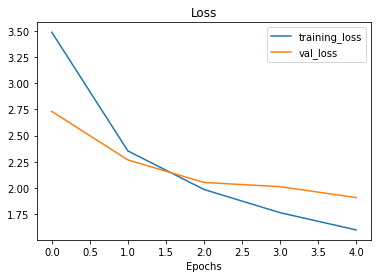

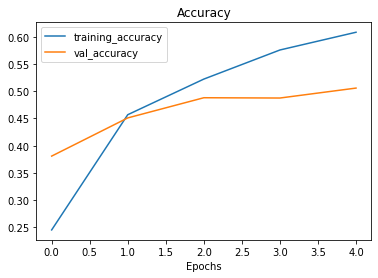

In [15]:
plot_loss_curves(history_all_classes_10_percent)

In [16]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [17]:
# Recompile model with lower learning rate
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
              metrics=['accuracy'])

In [18]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling True
output_layer True


In [19]:
# Check which layers are trainable
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [20]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs, this is the total number of epochs we're after (5+5=10)

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)), # validate on 15% of the test data
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1]) # start from previous last epoch


Epoch 5/10
237/237 [==============================] - 48s 177ms/step - loss: 1.3635 - accuracy: 0.6458 - val_loss: 1.9320 - val_accuracy: 0.4987
Epoch 6/10
237/237 [==============================] - 37s 157ms/step - loss: 1.2326 - accuracy: 0.6766 - val_loss: 1.9010 - val_accuracy: 0.5119
Epoch 7/10
237/237 [==============================] - 36s 152ms/step - loss: 1.1538 - accuracy: 0.6911 - val_loss: 1.8614 - val_accuracy: 0.5183
Epoch 8/10
237/237 [==============================] - 35s 147ms/step - loss: 1.0851 - accuracy: 0.7138 - val_loss: 1.8329 - val_accuracy: 0.5249
Epoch 9/10
237/237 [==============================] - 34s 142ms/step - loss: 1.0327 - accuracy: 0.7295 - val_loss: 1.8491 - val_accuracy: 0.5220
Epoch 10/10
237/237 [==============================] - 34s 142ms/step - loss: 0.9661 - accuracy: 0.7451 - val_loss: 1.8567 - val_accuracy: 0.5236


In [21]:
# Evaluate fine-tuned model on the whole test dataset
results_all_classes_10_percent_fine_tune = model.evaluate(test_data)
results_all_classes_10_percent_fine_tune

790/790 [==============================] - 52s 66ms/step - loss: 1.5867 - accuracy: 0.5825


[1.5867390632629395, 0.5824554562568665]

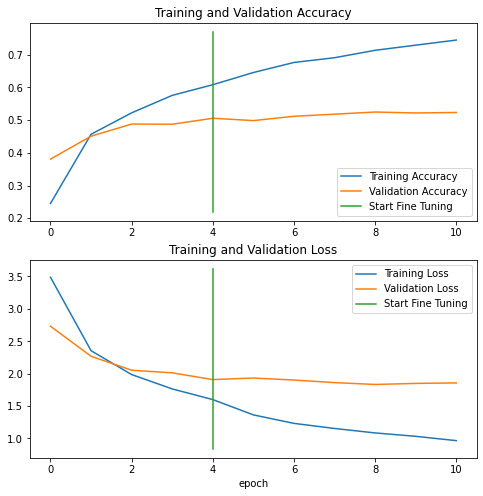

In [22]:
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

In [5]:
import tensorflow as tf

# Download pre-trained model from Google Storage (like a cooking show, I trained this model earlier, so the results may be different than above)
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
saved_model_path = "06_101_food_class_10_percent_saved_big_dog_model.zip"
# unzip_data(saved_model_path)

# Note: loading a model will output a lot of 'WARNINGS', these can be ignored: https://www.tensorflow.org/tutorials/keras/save_and_load#save_checkpoints_during_training
# There's also a thread on GitHub trying to fix these warnings: https://github.com/tensorflow/tensorflow/issues/40166
# model = tf.keras.models.load_model("drive/My Drive/tensorflow_course/101_food_class_10_percent_saved_big_dog_model/") # path to drive model
model = tf.keras.models.load_model(saved_model_path.split(".")[0]) # don't include ".zip" in loaded model path

In [6]:
# Check to see if loaded model is a trained model
loaded_loss, loaded_accuracy = model.evaluate(test_data)
loaded_loss, loaded_accuracy

790/790 [==============================] - 60s 66ms/step - loss: 1.8027 - accuracy: 0.6078


(1.802741289138794, 0.6078019738197327)

In [7]:
# Make predictions with model
pred_probs = model.predict(test_data, verbose=1) # set verbosity to see how long it will take 

790/790 [==============================] - 51s 63ms/step


In [8]:
# How many predictions are there?
len(pred_probs)

25250

In [9]:
# What's the shape of our predictions?
pred_probs.shape

(25250, 101)

In [10]:
# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

# How do they look?
pred_classes[1000:1100
            ]

array([21,  4,  4, 10,  4,  4, 79,  4, 93, 37, 16,  4,  4, 99,  4,  4, 99,
        4, 26,  4, 39, 96, 99, 79,  4,  4, 77, 12, 53,  4,  4,  4, 99, 26,
       99,  4, 79,  4,  4, 77,  4, 10, 77, 99,  4, 16,  8,  4,  4, 26, 98,
        4,  4,  4, 16,  4,  4, 37,  4,  4,  4, 93, 92,  4, 99, 39, 37,  4,
       85,  4, 21, 37, 12,  5,  3,  4, 37, 36, 99,  4, 93,  4,  4,  5,  4,
       99,  4, 77, 28, 37, 37, 90,  4, 39, 39,  4, 16, 93,  4, 99],
      dtype=int64)

In [11]:
# Note: This might take a minute or so due to unravelling 790 batches
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[1000:1100] # check what they look like (unshuffled)

[4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4]

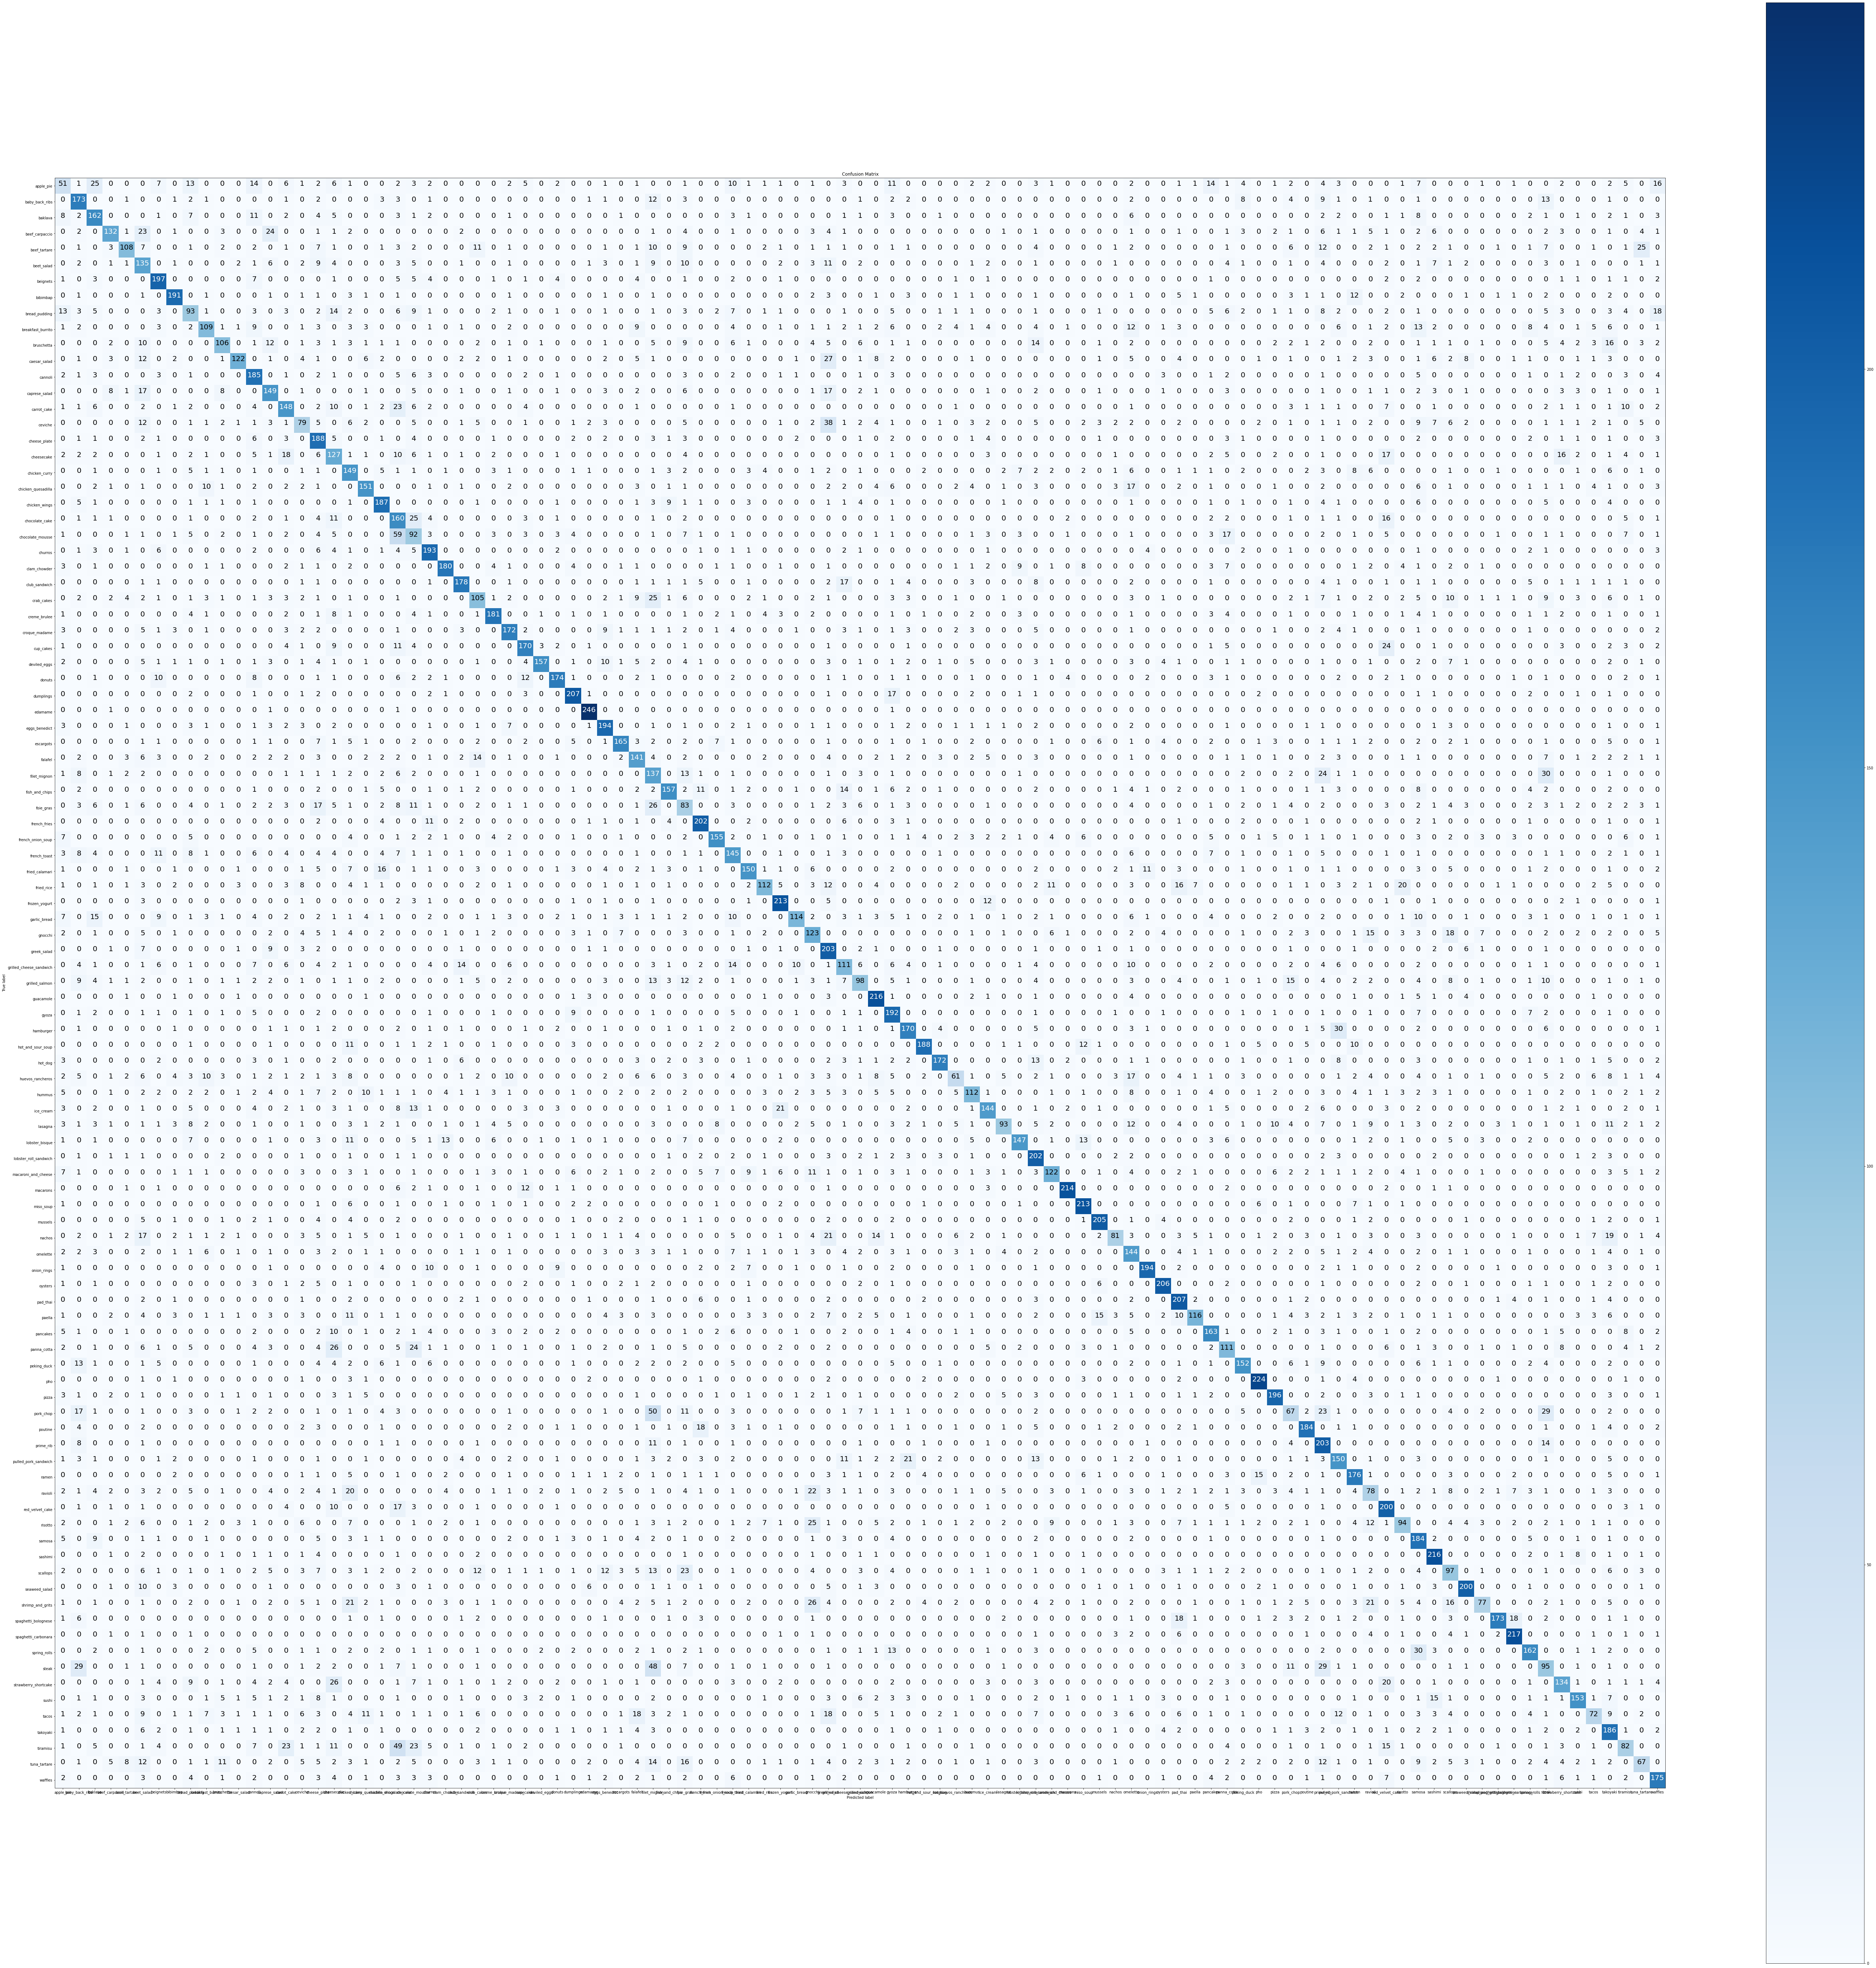

In [12]:
from helper_functions import make_confusion_matrix

# Get the class names
class_names = test_data.class_names
class_names


# Plot a confusion matrix with all 25250 predictions, ground truth labels and 101 classes
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

In [13]:
from sklearn.metrics import classification_report

print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

In [14]:
!pip install -U scikit-learn

In [15]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584903,
  'support': 250},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250},
 '2': {'precision': 0.5625,
  'recall': 0.648,
  'f1-score': 0.6022304832713754,
  'support': 250},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250},
 '4': {'precision': 0.7346938775510204,
  'recall': 0.432,
  'f1-score': 0.544080604534005,
  'support': 250},
 '5': {'precision': 0.34177215189873417,
  'recall': 0.54,
  'f1-score': 0.41860465116279066,
  'support': 250},
 '6': {'precision': 0.6677966101694915,
  'recall': 0.788,
  'f1-score': 0.7229357798165138,
  'support': 250},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511386,
  'support': 250},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'support': 250},
 '9

In [16]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee': 0.7494824016

In [17]:
import pandas as pd

f1 = pd.DataFrame({"class_name":list(class_f1_scores.keys()),
                   "f1-score": class_f1_scores.values()})
f1

,class_name,f1-score
0,apple_pie,0.240566
1,baby_back_ribs,0.586441
2,baklava,0.602230
3,beef_carpaccio,0.616822
4,beef_tartare,0.544081
...,...,...
96,tacos,0.380952
97,takoyaki,0.564492
98,tiramisu,0.385882
99,tuna_tartare,0.353562


In [18]:
f1= f1.sort_values(by = 'f1-score', ascending=True)
f1

,class_name,f1-score
0,apple_pie,0.240566
39,foie_gras,0.297491
77,pork_chop,0.308756
22,chocolate_mousse,0.329159
56,huevos_rancheros,0.339833
...,...,...
69,oysters,0.834008
91,spaghetti_carbonara,0.847656
75,pho,0.866538
63,macarons,0.895397


<AxesSubplot:ylabel='class_name'>

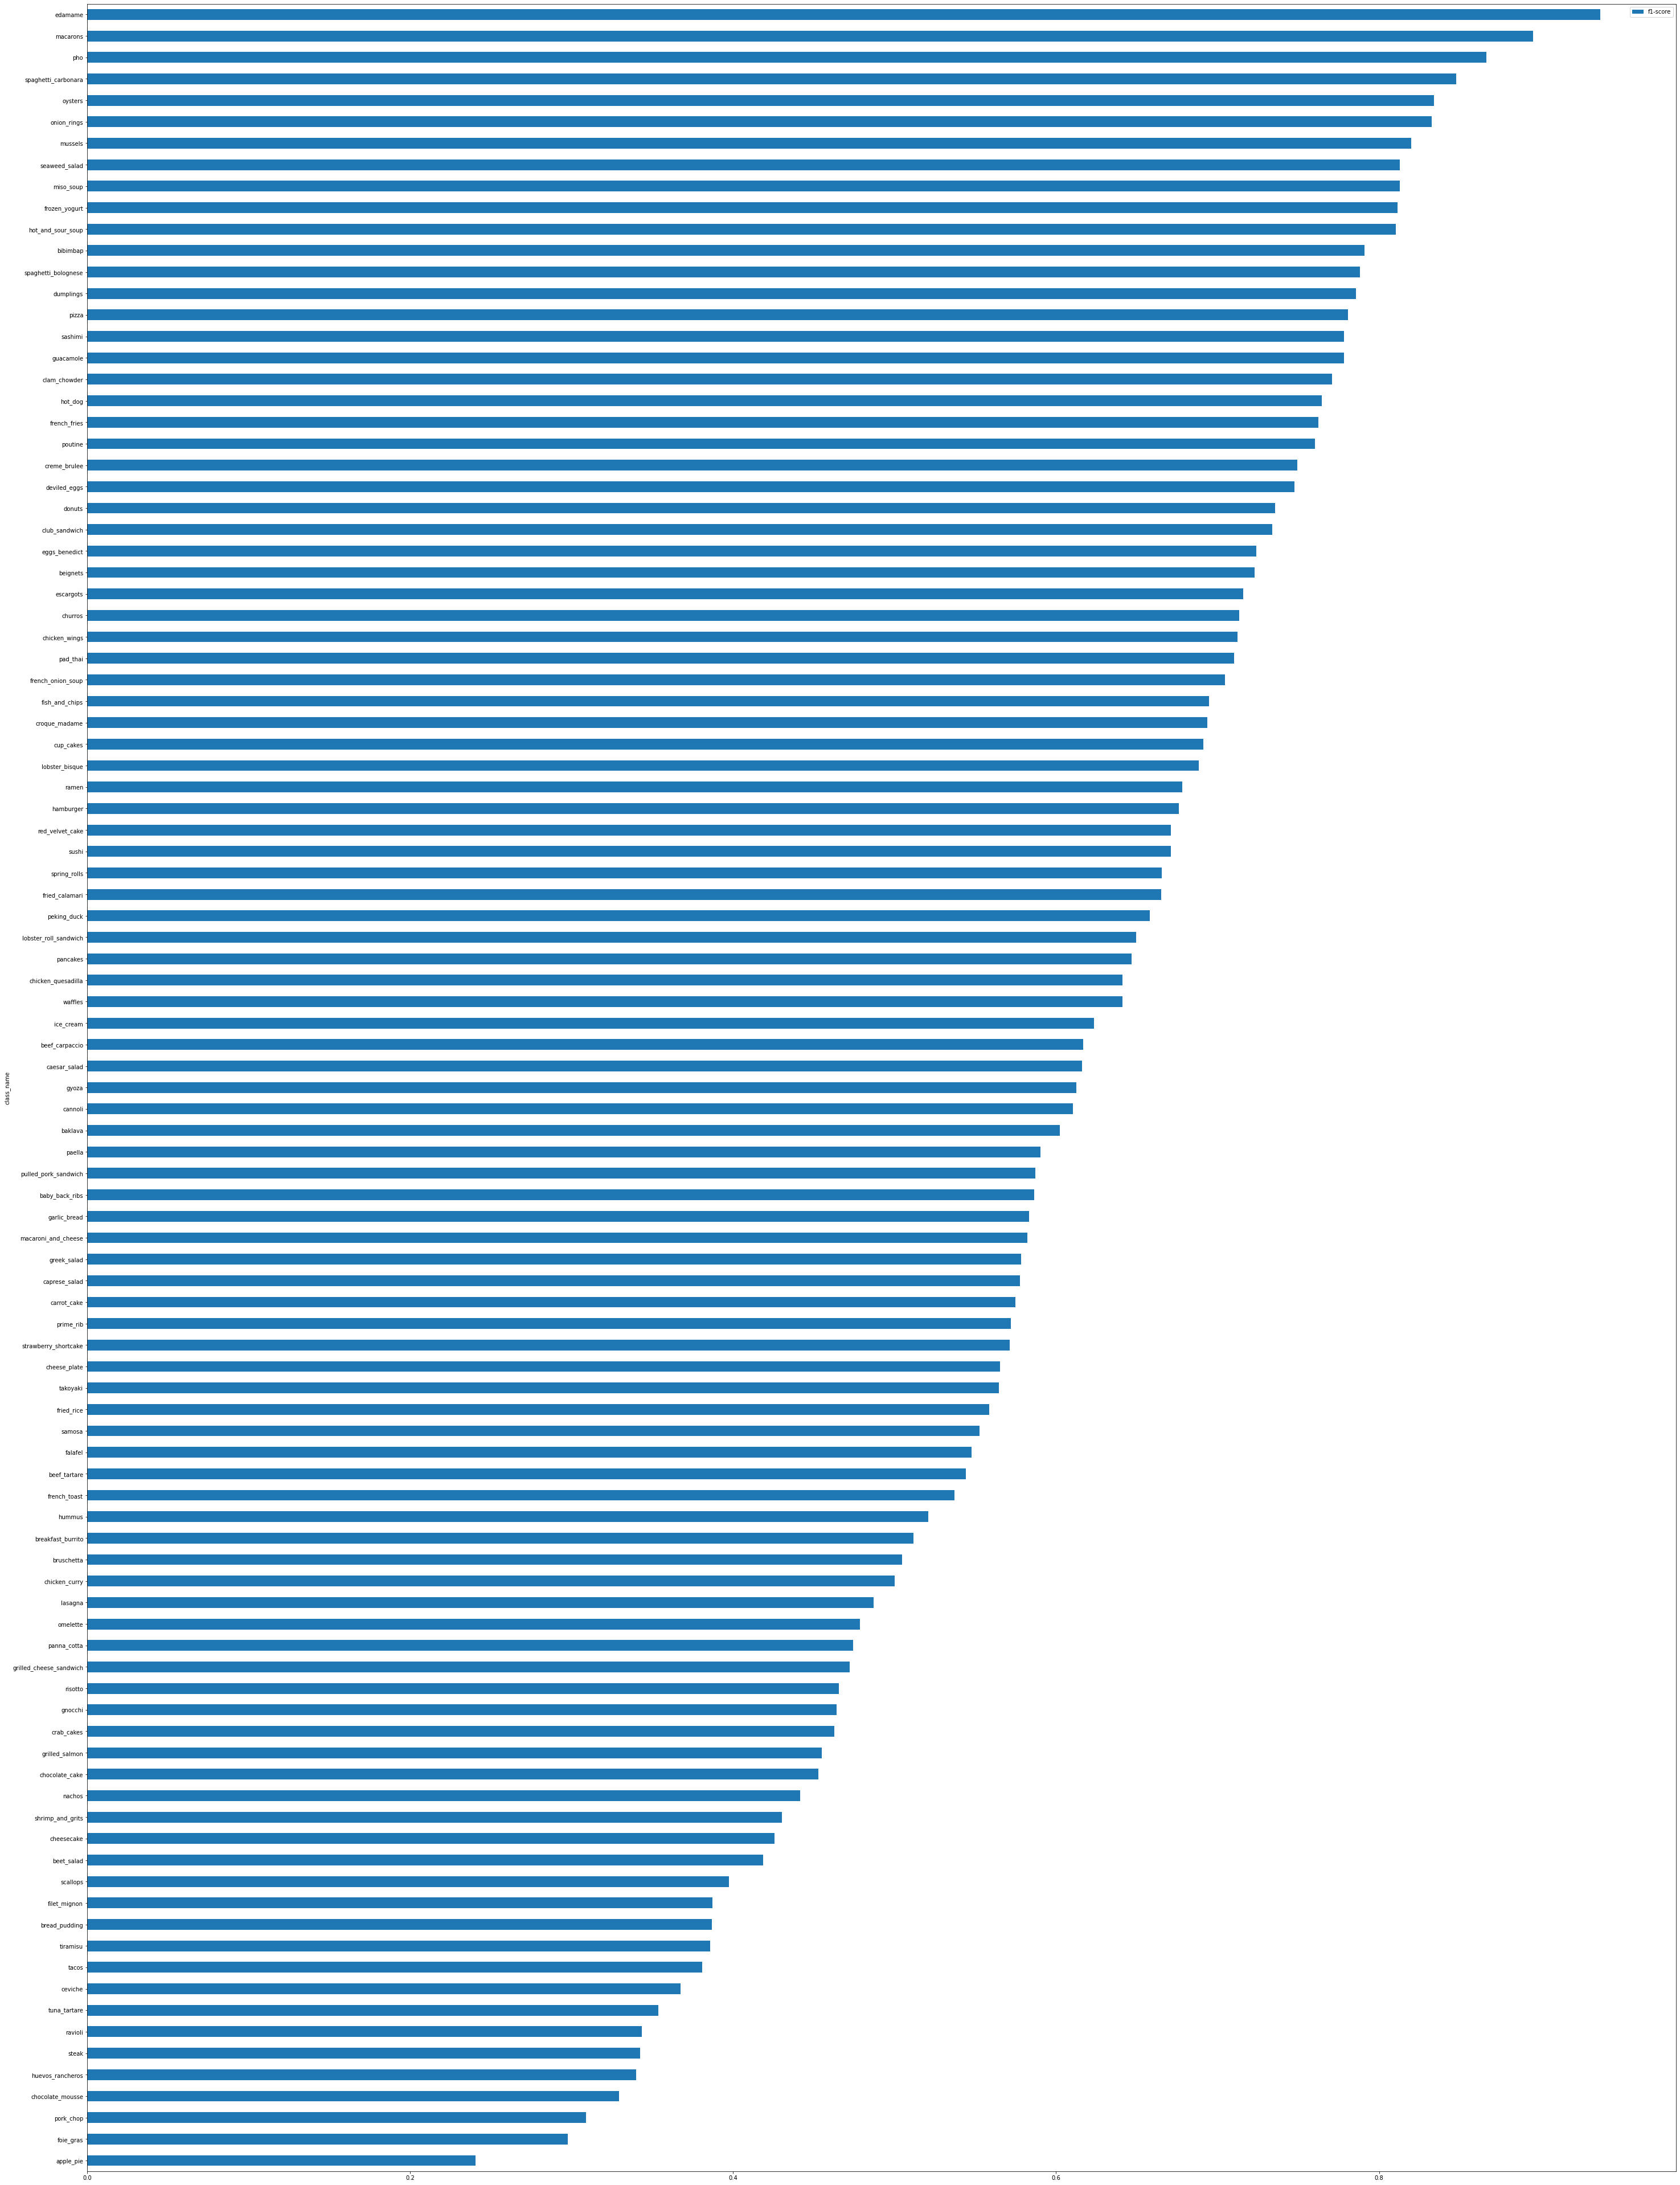

In [19]:
f1.plot(kind='barh', x="class_name",y="f1-score", figsize=(50,70), legend=True)

In [20]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

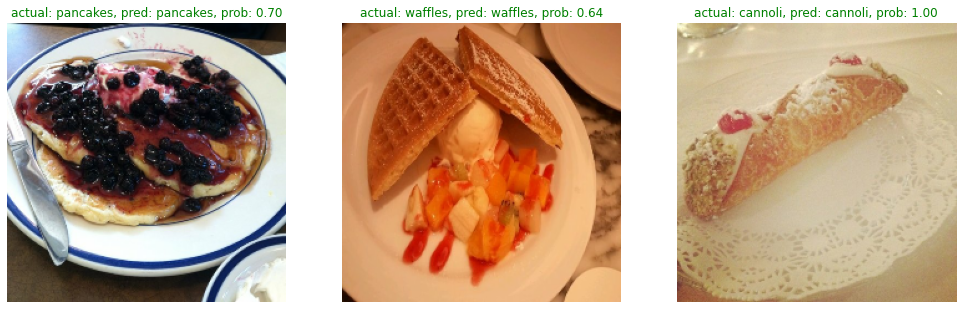

In [21]:
# Make preds on a series of random images
import os
import random
import matplotlib.pyplot as plt

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class 
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class 

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

In [24]:
import numpy as np

In [48]:
# 1. Get the filenames of all of our test data
filepaths = []
for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg", 
                                     shuffle=False):
    filepaths.append(filepath.numpy().decode("utf-8") )
filepaths[:10]

['101_food_classes_10_percent\\test\\apple_pie\\1011328.jpg',
 '101_food_classes_10_percent\\test\\apple_pie\\101251.jpg',
 '101_food_classes_10_percent\\test\\apple_pie\\1034399.jpg',
 '101_food_classes_10_percent\\test\\apple_pie\\103801.jpg',
 '101_food_classes_10_percent\\test\\apple_pie\\1038694.jpg',
 '101_food_classes_10_percent\\test\\apple_pie\\1047447.jpg',
 '101_food_classes_10_percent\\test\\apple_pie\\1068632.jpg',
 '101_food_classes_10_percent\\test\\apple_pie\\110043.jpg',
 '101_food_classes_10_percent\\test\\apple_pie\\1106961.jpg',
 '101_food_classes_10_percent\\test\\apple_pie\\1113017.jpg']

In [49]:
df_2 = pd.DataFrame({'filepaths': filepaths})
df_2

,filepaths
0,101_food_classes_10_percent\test\apple_pie\101...
1,101_food_classes_10_percent\test\apple_pie\101...
2,101_food_classes_10_percent\test\apple_pie\103...
3,101_food_classes_10_percent\test\apple_pie\103...
4,101_food_classes_10_percent\test\apple_pie\103...
...,...
25245,101_food_classes_10_percent\test\waffles\94200...
25246,101_food_classes_10_percent\test\waffles\95402...
25247,101_food_classes_10_percent\test\waffles\96181...
25248,101_food_classes_10_percent\test\waffles\97015...


In [50]:
from pathlib import Path

In [59]:
graund_class = Path(df_2.loc[0, "filepaths"]).parts[-2]
graund_class

'apple_pie'

In [65]:
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true":y_labels,
                        "y_pred":pred_classes,
                        "pred_conf":pred_probs.max(axis=1),
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]
                        })
pred_df

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname
0,101_food_classes_10_percent\test\apple_pie\101...,0,52,0.847479,apple_pie,gyoza
1,101_food_classes_10_percent\test\apple_pie\101...,0,0,0.964069,apple_pie,apple_pie
2,101_food_classes_10_percent\test\apple_pie\103...,0,0,0.959188,apple_pie,apple_pie
3,101_food_classes_10_percent\test\apple_pie\103...,0,80,0.658510,apple_pie,pulled_pork_sandwich
4,101_food_classes_10_percent\test\apple_pie\103...,0,79,0.367951,apple_pie,prime_rib
...,...,...,...,...,...,...
25245,101_food_classes_10_percent\test\waffles\94200...,100,100,0.972860,waffles,waffles
25246,101_food_classes_10_percent\test\waffles\95402...,100,16,0.877790,waffles,cheese_plate
25247,101_food_classes_10_percent\test\waffles\96181...,100,100,0.537708,waffles,waffles
25248,101_food_classes_10_percent\test\waffles\97015...,100,94,0.502263,waffles,strawberry_shortcake


In [84]:
for i in pred_df.index:
    if pred_df.loc[i, "y_true_classname"] == pred_df.loc[i, "y_pred_classname"]:
        pred_df.loc[i, "condition"] = True
    else:
        pred_df.loc[i, "condition"] = False
pred_df

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,condition
21810,101_food_classes_10_percent\test\scallops\1784...,87,29,0.999997,scallops,cup_cakes,False
231,101_food_classes_10_percent\test\apple_pie\827...,0,100,0.999995,apple_pie,waffles,False
15359,101_food_classes_10_percent\test\lobster_roll_...,61,53,0.999988,lobster_roll_sandwich,hamburger,False
23539,101_food_classes_10_percent\test\strawberry_sh...,94,83,0.999987,strawberry_shortcake,red_velvet_cake,False
21400,101_food_classes_10_percent\test\samosa\314001...,85,92,0.999981,samosa,spring_rolls,False
...,...,...,...,...,...,...,...
20323,101_food_classes_10_percent\test\ramen\2104074...,81,81,0.166974,ramen,ramen,True
15698,101_food_classes_10_percent\test\macaroni_and_...,62,62,0.162394,macaroni_and_cheese,macaroni_and_cheese,True
19254,101_food_classes_10_percent\test\pork_chop\104...,77,77,0.161415,pork_chop,pork_chop,True
2060,101_food_classes_10_percent\test\bread_pudding...,8,8,0.157323,bread_pudding,bread_pudding,True


In [89]:
pred_df = pred_df.sort_values(["condition", "pred_conf"], ascending = [True, False])
pred_df = pred_df.reset_index(drop=True)
pred_df

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,condition
0,101_food_classes_10_percent\test\scallops\1784...,87,29,0.999997,scallops,cup_cakes,False
1,101_food_classes_10_percent\test\apple_pie\827...,0,100,0.999995,apple_pie,waffles,False
2,101_food_classes_10_percent\test\lobster_roll_...,61,53,0.999988,lobster_roll_sandwich,hamburger,False
3,101_food_classes_10_percent\test\strawberry_sh...,94,83,0.999987,strawberry_shortcake,red_velvet_cake,False
4,101_food_classes_10_percent\test\samosa\314001...,85,92,0.999981,samosa,spring_rolls,False
...,...,...,...,...,...,...,...
25245,101_food_classes_10_percent\test\ramen\2104074...,81,81,0.166974,ramen,ramen,True
25246,101_food_classes_10_percent\test\macaroni_and_...,62,62,0.162394,macaroni_and_cheese,macaroni_and_cheese,True
25247,101_food_classes_10_percent\test\pork_chop\104...,77,77,0.161415,pork_chop,pork_chop,True
25248,101_food_classes_10_percent\test\bread_pudding...,8,8,0.157323,bread_pudding,bread_pudding,True


In [90]:
for i in pred_df.index:
    if pred_df.loc[i, "pred_conf"] < 0.95:
        pred_df = pred_df.drop(pred_df.index[i:])
        break
pred_df

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,condition
0,101_food_classes_10_percent\test\scallops\1784...,87,29,0.999997,scallops,cup_cakes,False
1,101_food_classes_10_percent\test\apple_pie\827...,0,100,0.999995,apple_pie,waffles,False
2,101_food_classes_10_percent\test\lobster_roll_...,61,53,0.999988,lobster_roll_sandwich,hamburger,False
3,101_food_classes_10_percent\test\strawberry_sh...,94,83,0.999987,strawberry_shortcake,red_velvet_cake,False
4,101_food_classes_10_percent\test\samosa\314001...,85,92,0.999981,samosa,spring_rolls,False
...,...,...,...,...,...,...,...
835,101_food_classes_10_percent\test\apple_pie\294...,0,42,0.950169,apple_pie,french_toast,False
836,101_food_classes_10_percent\test\lobster_bisqu...,60,64,0.950167,lobster_bisque,miso_soup,False
837,101_food_classes_10_percent\test\chocolate_cak...,21,22,0.950165,chocolate_cake,chocolate_mousse,False
838,101_food_classes_10_percent\test\hamburger\740...,53,100,0.950111,hamburger,waffles,False


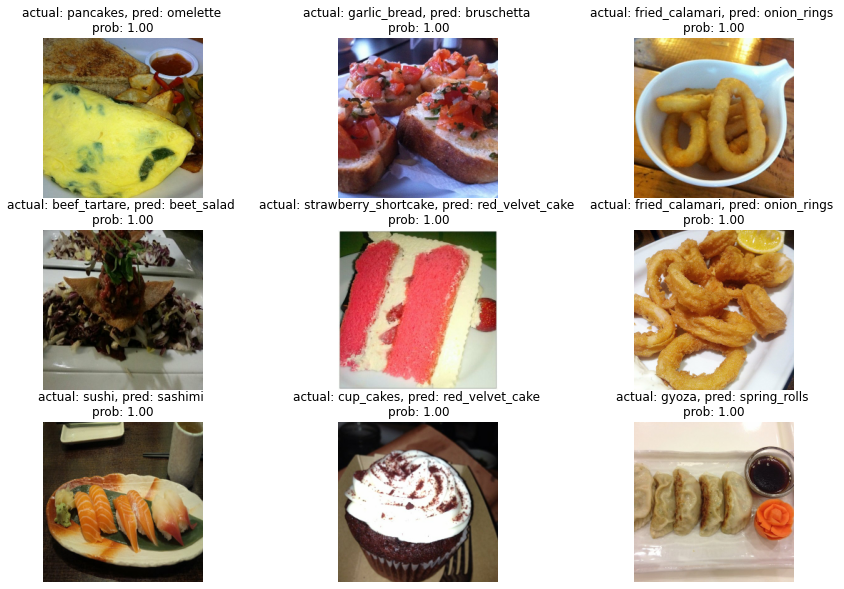

In [92]:

# 5. Visualize some of the most wrong examples
images_to_view = 9
start_index = 10 # change the start index to view more
plt.figure(figsize=(15, 10))
for i, row in enumerate(pred_df[start_index:start_index+images_to_view].itertuples()): 
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False)